In [ ]:
import pl_bolts.utils

In [1]:
import os
import sys

os.chdir('/data/l989o/deployed/a')
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')

In [2]:
import torch
from torch.utils.data import DataLoader
from models.ae_conv_vae_lightning import VAE, RGBCells
import numpy as np

Global seed set to 1234


fino a qui tutto bene


In [3]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
import PIL
import random
from torch import nn

# checking the augmented data

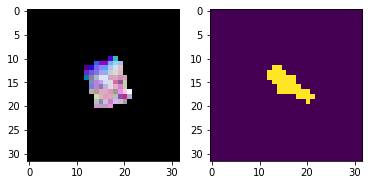

In [4]:
%matplotlib inline
val_ds = RGBCells('validation', augment=True, aggressive_rotation=True)
n = len(val_ds)
i = random.randrange(0, n)
data = val_ds[i]
ome = data[0]
mask = data[1]
ome = ome.permute(1, 2, 0).numpy()
mask = mask.permute(1, 2, 0).numpy().astype(np.bool)
def scale(x):
    a = np.amin(x, axis=(0, 1))
    b = np.amax(x, axis=(0, 1))
    return (x - a) / (b - a)
ome = scale(ome)
axes = plt.subplots(1, 2)[1].flatten()
ax = axes[0]
ax.imshow(ome)
ax = axes[1]
ax.imshow(mask)
plt.show()

In [5]:
mask.shape
np.tile(mask, (1, 1, 3)).shape

(32, 32, 3)

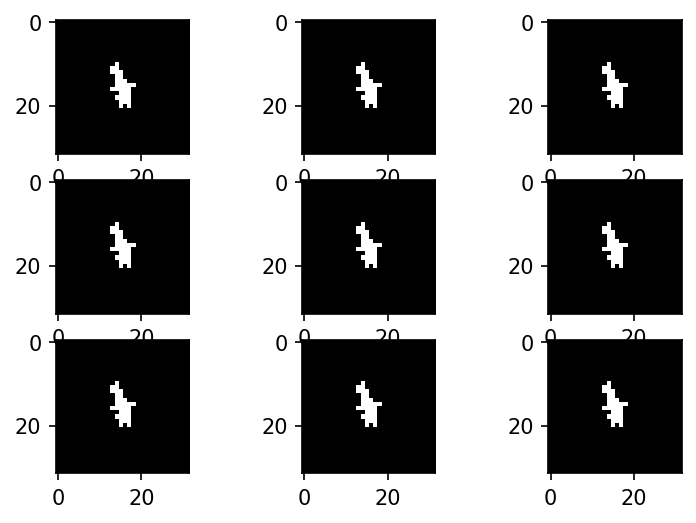

In [6]:
t = transforms.Compose([
    transforms.RandomApply(nn.ModuleList([transforms.RandomRotation(degrees=360)])),
])
mask = mask.astype(float)
rgb_mask = np.tile(mask, (1, 1, 3))
rgb_mask *= 255
rgb_mask = rgb_mask.astype(np.uint8)
axes = plt.subplots(3, 3, dpi=150)[1].flatten()
all_identical = set()
state = torch.get_rng_state()
for ax in axes:
    torch.set_rng_state(state)
    x = t(PIL.Image.fromarray(rgb_mask))
    ax.imshow(x)
    all_identical.add(tuple(np.array(x).flatten().tolist()))
assert len(all_identical) == 1

# checking the reconstruction

In [7]:
model_path = '/data/l989o/spatial_uzh/data/spatial_uzh_processed/a/checkpoints/resnet_vae/version_115/checkpoints'
l = os.listdir(model_path)
assert len(l) == 1
assert l[0].endswith('.ckpt')
l

['epoch=19-step=8739.ckpt']

In [8]:
checkpoint = os.path.join(model_path, l[0])

In [ ]:
model = VAE.load_from_checkpoint(checkpoint)

In [ ]:
val_ds = RGBCells('validation', augment=True, aggressive_rotation=True)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=8, pin_memory=True, shuffle=True)
data = val_loader.__iter__().__next__()

In [ ]:
model = model.cuda()
data = [d.to(model.device) for d in data]

In [ ]:
%%time
with torch.no_grad():
    z = [zz.cpu() for zz in model(*data)]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
COOL_CHANNELS = [0, 10, 20]

def get_scale_location():
    mean = np.array([0.3128328, 0.08154685, 0.02617499, 0.31149776, 0.10011313,
                     0.13143819, 0.04897958, 0.05522078, 0.02628855, 0.12524123,
                     0.15552816, 0.08004793, 0.13349437, 0.02045013, 0.04155505,
                     0.07637688, 0.05526352, 0.04818857, 0.11221485, 0.01779799,
                     0.53215206, 0.08219107, 0.03510931, 0.08550659, 0.02237169,
                     0.02657647, 0.09854327, 0.22031476, 0.04274541, 0.06778383,
                     0.24079644, 0.09004467, 0.0234197, 0.13312621, 0.04914724,
                     0.29719813, 0.10172928, 0.18843424, 0.25893724])
    std = np.sqrt(np.array([0.81152901, 0.11195328, 0.03844969, 0.76020458, 0.19636732,
                            0.30648388, 0.06448294, 0.08879372, 0.03747649, 0.32956727,
                            0.40133228, 0.11878445, 0.24177647, 0.02510913, 0.05398327,
                            0.15110854, 0.09525968, 0.07278724, 0.17972434, 0.01950939,
                            1.73329118, 0.11334923, 0.04934192, 0.15689578, 0.02762272,
                            0.03045641, 0.16039316, 0.49438282, 0.07485281, 0.10151964,
                            0.45035213, 0.15424273, 0.02854364, 0.23177609, 0.09494518,
                            0.98995058, 0.14861627, 0.41785507, 0.66190155]))
    mean = mean[COOL_CHANNELS]
    std = std[COOL_CHANNELS]
    return mean, std

def get_quantiles():
    quantiles_for_normalization = np.array([4.0549, 1.8684, 1.3117, 3.8141, 2.6172, 3.1571, 1.4984, 1.8866, 1.2621,
                                        3.7035, 3.6496, 1.8566, 2.5784, 0.9939, 1.4314, 2.1803, 1.8672, 1.6674,
                                        2.3555, 0.8917, 5.1779, 1.8002, 1.4042, 2.3873, 1.0509, 1.0892, 2.2708,
                                        3.4417, 1.8348, 1.8449, 2.8699, 2.2071, 1.0464, 2.5855, 2.0384, 4.8609,
                                        2.0277, 3.3281, 3.9273])[COOL_CHANNELS]
    return quantiles_for_normalization

In [ ]:
print(model.negative_binomial_p_logit)
print(torch.sigmoid(model.negative_binomial_p_logit))

In [ ]:
%matplotlib inline

quantiles = get_quantiles()
loader = val_loader
all_originals = []
all_originals_masked = []
all_reconstructed = []
all_reconstructed_masked = []
mask_color = torch.tensor([x / 255 for x in [254, 112, 31]]).float()
new_size = (128, 128)
upscale = transforms.Resize(new_size, interpolation=PIL.Image.NEAREST)
n = 15
with torch.no_grad():
    batch = loader.__iter__().__next__()
    omes = batch[0]
    masks = batch[1]
    assert len(omes.shape) == 4
    assert len(omes) >= n
    data = omes[:n].to(model.device)
    masks_data = masks[:n].to(model.device)
    pred = model.forward(data, masks_data)[0]
n_channels = data.shape[1]
all_original_c = {c: [] for c in range(n_channels)}
all_original_masked_c = {c: [] for c in range(n_channels)}
all_reconstructed_c = {c: [] for c in range(n_channels)}
all_reconstructed_masked_c = {c: [] for c in range(n_channels)}

for i in range(n):
    original = data[i].cpu().permute(1, 2, 0) * quantiles
    r_hat = pred[i].cpu().permute(1, 2, 0)
    p = model.boosted_sigmoid(model.negative_binomial_p_logit).cpu().detach()
    mean = model.negative_binomial_mean(r=r_hat, p=p)
    reconstructed = mean * quantiles
    
    a_original = original.amin(dim=(0, 1))
    b_original = original.amax(dim=(0, 1))
    m = masks_data[i].cpu().bool()
    mm = torch.squeeze(m, 0)
    reconstructed_flattened = torch.reshape(reconstructed, (-1, reconstructed.shape[-1]))
    mask_flattened = mm.flatten()
    a_reconstructed = reconstructed_flattened[mask_flattened, :].amin(dim=0)
    b_reconstructed = reconstructed_flattened[mask_flattened, :].amax(dim=0)
    a = torch.min(a_original, a_reconstructed)
    b = torch.max(b_original, b_reconstructed)
    
    original = ((original - a) / (b - a)).float()
    reconstructed = ((reconstructed - a) / (b - a)).float()
    
    mm_not = torch.logical_not(mm)
    assert torch.all(reconstructed[mm, :] >=0.)
    assert torch.all(reconstructed[mm, :] <= 1.)
    reconstructed = torch.clamp(reconstructed, 0., 1.)
    
    original_masked = original.clone()
    original_masked[mm_not, :] = mask_color
    reconstructed_masked = reconstructed.clone()
    reconstructed_masked[mm_not, :] = mask_color
    
    upscaled_mm = upscale(m).squeeze(0)
    upscaled_mm_not = torch.logical_not(upscale(m).squeeze(0))
    for c in range(n_channels):
        original_c = original[:, :, c]
        original_c = torch.stack([original_c] * 3, dim=2)

        reconstructed_c = reconstructed[:, :, c]
        reconstructed_c = torch.stack([reconstructed_c] * 3, dim=2)
        
        def f(t):
            t = t.permute(2, 0, 1)
            t = upscale(t)
            return t
        
        def overlay_mask(t):
            t = t.clone()
            t[mm_not, :] = mask_color
            return t
            
        a_original_c = original_c.amin(dim=(0, 1))
        b_original_c = original_c.amax(dim=(0, 1))
        reconstructed_flattened_c = torch.reshape(reconstructed_c, (-1, reconstructed_c.shape[-1]))
        mask_flattened = mm.flatten()
        a_reconstructed_c = reconstructed_flattened_c[mask_flattened, :].amin(dim=0)
        b_reconstructed_c = reconstructed_flattened_c[mask_flattened, :].amax(dim=0)
        a_c = torch.min(a_original_c, a_reconstructed_c)
        b_c = torch.max(b_original_c, b_reconstructed_c)
        
        t = (original_c - a_c) / (b_c - a_c)
        all_original_c[c].append(f(t))
        all_original_masked_c[c].append(f(overlay_mask(t)))
        t = (reconstructed_c - a_c) / (b_c - a_c)
        all_reconstructed_c[c].append(f(t))
        all_reconstructed_masked_c[c].append(f(overlay_mask(t)))
    
    original = upscale(original.permute(2, 0, 1))
    reconstructed = upscale(reconstructed.permute(2, 0, 1))
    original_masked = upscale(original_masked.permute(2, 0, 1))
    reconstructed_masked = upscale(reconstructed_masked.permute(2, 0, 1))
    
    all_originals.append(original)
    all_reconstructed.append(reconstructed)
    all_originals_masked.append(original_masked)
    all_reconstructed_masked.append(reconstructed_masked)
    
l = all_originals + all_reconstructed + all_originals_masked + all_reconstructed_masked
for c in range(n_channels):
    l += (all_original_c[c] + all_reconstructed_c[c] + all_original_masked_c[c] + all_reconstructed_masked_c[c])
    
img = make_grid(l, nrow=n)
plt.figure(figsize=(30, 30))
im = img.permute(1, 2, 0).numpy()
print(im.shape, im.min(), im.max())
plt.imshow(im)
plt.show()

In [ ]:
def f(x):
    a = []
    b = []
    for tt in x:
        a.append(tt.min().item())
        b.append(tt.max().item())
    print(a)
    print(b)
    print()
f(all_originals)
f(all_reconstructed)
f(all_originals_masked)
f(all_reconstructed_masked)

In [ ]:
for c in range(n_channels):
    print('channel', c)
    f(all_original_c[c])
    f(all_reconstructed_c[c])
    f(all_original_masked_c[c])
    f(all_reconstructed_masked_c[c])

# checking the embeddings

In [ ]:
train_ds = RGBCells('train')
val_ds = RGBCells('validation')
train_loader = DataLoader(train_ds, batch_size=512, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=512, num_workers=8, pin_memory=True)

In [ ]:
from tqdm import tqdm

quantiles = get_quantiles()
loader = val_loader
n = 0
mus = []
stds = []
with torch.no_grad():
    for batch in tqdm(loader):
        omes = batch[0]
        masks = batch[1]
        assert len(omes.shape) == 4
        data = omes.to(model.device)
        masks_data = masks.to(model.device)
        pred, mu, std, _ = model.forward(data, masks_data)
        mus.append(mu.cpu())
        stds.append(std.cpu())
        n += len(mu)
        if n > 10000:
            break

In [ ]:
all_mus = torch.cat(mus, dim=0)
all_stds = torch.cat(stds, dim=0)
print(all_mus.shape)
print(all_stds.shape)

In [ ]:
print(torch.sum(all_mus.isinf()))
print(torch.sum(all_mus.isnan()))
print(torch.sum(all_stds.isinf()))
print(torch.sum(all_stds.isnan()))

In [ ]:
import scanpy as sc
import anndata as ad

In [ ]:
a = ad.AnnData(all_mus.numpy())

sc.tl.pca(a, svd_solver='arpack')
sc.pl.pca(a, color='0')
sc.pl.pca_variance_ratio(a)
# sc.pl.pca_variance_ratio(a, log=True)
sc.pp.neighbors(a)
sc.tl.leiden(a)
sc.tl.umap(a)
sc.pl.umap(a, color='leiden')